In [1]:
!pip install -q pyomo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.4 MB/s eta 0:00:00


In [2]:
# https://jckantor.github.io/ND-Pyomo-Cookbook/notebooks/01.02-Running-Pyomo-on-Google-Colab.html#installing-pyomo-and-solvers
%%capture
import sys
import os

if 'google.colab' in sys.modules:
    !pip install idaes-pse --pre
    !idaes get-extensions --to ./bin
    os.environ['PATH'] += ':bin'

In [3]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from pyomo.opt import SolverStatus, TerminationCondition
from pyomo.environ import *
import time

### Price and Access Fair Model

In [4]:
from functools import total_ordering
from re import sub
from pyomo.environ import *

def fair_model(M_star, market, b, n, m, alpha=0.5, criteria='Price', solver='couenne'):
  L = [i for i in range(1,n+1)]
  C = [i for i in range(0,m+1)] # # of Cars in 2

  # Step 1: Create an instance of the model
  model = ConcreteModel()

  # Step 2: Define the decision
  model.pi = Var(L, domain = NonNegativeReals)
  model.r = Var(C, domain = NonNegativeReals)
  model.q = Var(L, L, domain = NonNegativeReals)

  # Step 3: Define Objective
  model.revenue = Objective(expr = sum([-log(model.q[i,j])/b[i,j]*market[i,j]*model.q[i,j]*model.pi[i] if i != j else 0 for i in L for j in L]), sense=maximize)

  # constraints
  model.c = ConstraintList()
  m_list = []
  for i in L:
    model.c.add(sum([market[i,j]*model.q[i,j]*model.pi[i] if i != j else 0 for j in L]) == sum([market[k,i]*model.q[k,i]*model.pi[k] if k!= i else 0 for k in L]))
    for j in L:
      model.c.add(model.q[i,j] <= 1)
      if i != j:
        m_list += [-log(model.q[i,j])/b[i,j]] if criteria == 'Price' else [model.q[i,j] * model.pi[i]]

  model.c.add(sum([model.r[i] for i in range(m+1)]) == 1)
  for i in range(0,m):
    model.c.add(model.r[i] * market[1,2] * model.q[1,2] == model.r[i+1] * market[2,1] * model.q[2,1])
  model.c.add(model.pi[1] == sum([model.r[i] for i in range(0,m)]))
  model.c.add(model.pi[2] == sum([model.r[i] for i in range(1,m+1)]))

  if alpha != 0:
    eps = 1e-3 if alpha == 1 else 0
    for i in range(len(m_list)):
      for j in range(i+1, len(m_list)):
        model.c.add(m_list[i] - m_list[j] <= (1-alpha) * M_star + eps)
        model.c.add(m_list[j] - m_list[i] <= (1-alpha) * M_star + eps)

  _solver = SolverFactory(solver)
  results = _solver.solve(model) #
  # results.write()
  p_ij, a_ij, org_q, sur = {}, {}, {}, {}

  for i in range(1, n+1):
    for j in range(1, n+1):
      org_q[i,j] = model.q[i,j]()
      if i != j:
        p_ij[i,j] = -log(model.q[i,j]())/b[i,j]
        a_ij[i,j] = model.q[i,j]() * model.pi[i]()
        sur[i,j] = model.q[i,j]() * model.pi[i]() / b[i,j]

  p_star, a_star = max(p_ij.values())-min(p_ij.values()), max(a_ij.values())-min(a_ij.values())
  star = {'p': p_star, 'a':a_star}
  return model, org_q, sur, p_ij, a_ij, star, {i: model.pi[i]() for i in L}

### Simulations

In [12]:
def subplot_drawing_n_2(criteria, revenue_list, total_surplus_list, surplus_list, price_list, access_list):
  N = 4
  fig, axs = plt.subplots(1, N)
  fig.set_figheight(4)
  fig.set_figwidth(24)

  size = 24
  n_iter = len(revenue_list)
  iter_list = [i/(n_iter-1) for i in range(n_iter)] if n_iter != 1 else [0]
  axs[0].plot(iter_list, revenue_list, color='r', label = r'$\mathcal{R}(\alpha)$', linewidth=3.0)
  axs[0].plot(iter_list, total_surplus_list, color='g', label = r'$\mathcal{S}(\alpha)$', linewidth=3.0)
  axs[0].plot(iter_list, [revenue_list[i] + total_surplus_list[i] for i in range(n_iter)], color='b', label = r'$\mathcal{W}(\alpha)$', linewidth=3.0)
  axs[0].set_xlim([0, 1])
  axs[0].grid()

  level = 1
  axs[1].plot(iter_list, [p[1,2] for p in price_list], label=r'$p_1$',linewidth=3.0, alpha=level)
  axs[1].plot(iter_list, [p[2,1] for p in price_list], label=r'$p_2$',linewidth=3.0, alpha=level)
  axs[1].set_xlim([0, 1])
  axs[1].grid()

  axs[2].plot(iter_list, [a[1,2] for a in access_list], label=r'$A_1$',linewidth=3.0, alpha=level)
  axs[2].plot(iter_list, [a[2,1] for a in access_list], label=r'$A_2$',linewidth=3.0, alpha=level)
  axs[2].set_xlim([0, 1])
  axs[2].grid()

  axs[3].plot(iter_list, [s[1,2] for s in surplus_list], label=r'$\mathcal{S}_1$',linewidth=3.0)
  axs[3].plot(iter_list, [s[2,1] for s in surplus_list], label=r'$\mathcal{S}_2$',linewidth=3.0)
  axs[3].set_xlim([0, 1])
  axs[3].grid()

  for i in range(N):
    box = axs[i].get_position()
    axs[i].legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), fancybox=True, shadow=True, ncol=3, prop={"size":16})

  for ax in axs.flat:
      ax.set(xlabel=r'$\alpha$')
      ax.xaxis.label.set_fontsize(28)

  plt.show()

In [13]:
def subplot_drawing(criteria, revenue_list, total_surplus_list, surplus_list, price_list, access_list):
  fig, axs = plt.subplots(1, 4)
  fig.set_figheight(3.5)
  fig.set_figwidth(24)

  size = 20
  n_iter = len(revenue_list)
  iter_list = [i/(n_iter-1) for i in range(n_iter)] if n_iter != 1 else [0]
  axs[0].plot(iter_list, revenue_list, color='r', label = r'$\mathcal{R}(\alpha)$', linewidth=3.0)
  axs[0].plot(iter_list, total_surplus_list, color='g', label = r'$\mathcal{S}(\alpha)$', linewidth=3.0)
  axs[0].plot(iter_list, [revenue_list[i] + total_surplus_list[i] for i in range(n_iter)], color='b', label = r'$\mathcal{W}(\alpha)$', linewidth=3.0)
  axs[0].set_xlim([0, 1])
  axs[0].grid()

  level = 0.8
  axs[1].plot(iter_list, [p[1,2] for p in price_list], label=r'$p_{12}$',linewidth=3.0, color='#069AF3', alpha=level)
  axs[1].plot(iter_list, [p[1,3] for p in price_list], label=r'$p_{13}$',linewidth=3.0, color='#0343DF', alpha=level)
  axs[1].plot(iter_list, [p[2,1] for p in price_list], label=r'$p_{21}$',linewidth=3.0, color='#FFA500', alpha=level)
  axs[1].plot(iter_list, [p[2,3] for p in price_list], label=r'$p_{23}$',linewidth=3.0, color='#FF4500', alpha=level)
  axs[1].plot(iter_list, [p[3,1] for p in price_list], label=r'$p_{31}$',linewidth=3.0, color='#15B01A', alpha=level)
  axs[1].plot(iter_list, [p[3,2] for p in price_list], label=r'$p_{32}$',linewidth=3.0, color='#006400', alpha=level)
  axs[1].set_xlim([0, 1])
  axs[1].grid()

  axs[2].plot(iter_list, [a[1,2] for a in access_list], label=r'$A_{12}$',linewidth=3.0, color='#069AF3', alpha=level)
  axs[2].plot(iter_list, [a[1,3] for a in access_list], label=r'$A_{13}$',linewidth=3.0, color='#0343DF', alpha=level)
  axs[2].plot(iter_list, [a[2,1] for a in access_list], label=r'$A_{21}$',linewidth=3.0, color='#FFA500', alpha=level)
  axs[2].plot(iter_list, [a[2,3] for a in access_list], label=r'$A_{23}$',linewidth=3.0, color='#FF4500', alpha=level)
  axs[2].plot(iter_list, [a[3,1] for a in access_list], label=r'$A_{31}$',linewidth=3.0, color='#15B01A', alpha=level)
  axs[2].plot(iter_list, [a[3,2] for a in access_list], label=r'$A_{32}$',linewidth=3.0, color='#006400', alpha=level)
  axs[2].set_xlim([0, 1])
  axs[2].grid()

  axs[3].plot(iter_list, [s[1,2] for s in surplus_list], label=r'$\mathcal{S}_{12}$',linewidth=3.0, color='#069AF3', alpha=level)
  axs[3].plot(iter_list, [s[1,3] for s in surplus_list], label=r'$\mathcal{S}_{13}$',linewidth=3.0, color='#0343DF', alpha=level)
  axs[3].plot(iter_list, [s[2,1] for s in surplus_list], label=r'$\mathcal{S}_{21}$',linewidth=3.0, color='#FFA500', alpha=level)
  axs[3].plot(iter_list, [s[2,3] for s in surplus_list], label=r'$\mathcal{S}_{23}$',linewidth=3.0, color='#FF4500', alpha=level)
  axs[3].plot(iter_list, [s[3,1] for s in surplus_list], label=r'$\mathcal{S}_{31}$',linewidth=3.0, color='#15B01A', alpha=level)
  axs[3].plot(iter_list, [s[3,2] for s in surplus_list], label=r'$\mathcal{S}_{32}$',linewidth=3.0, color='#006400', alpha=level)
  axs[3].set_xlim([0, 1])
  axs[3].grid()

  for i in range(4):
    box = axs[i].get_position()
    axs[i].set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])

    # Put a legend below current axis
    axs[i].legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), fancybox=True, shadow=True, ncol=3, prop={"size":10})
    # else:
    #   axs[i].legend(loc='upper center', bbox_to_anchor=(0.5, 1.25),
    #                 fancybox=True, shadow=True, ncol=3, prop={"size":12})

  for ax in axs.flat:
      ax.set(xlabel=r'$\alpha$')
      ax.xaxis.label.set_fontsize(18) #28

  plt.show()

In [14]:
def subplot_overlapping(price_all, revenue_all, surplus_all, total_surplus_all, access_all):

  fig, axs = plt.subplots(1, 4)
  fig.set_figheight(3.5)
  fig.set_figwidth(24)

  size = 28

  for i in range(len(price_whole)):

    price_list, revenue_list, surplus_list, total_surplus_list, access_list = price_all[i], revenue_all[i], surplus_all[i], total_surplus_all[i], access_all[i]

    n_iter = len(revenue_list)
    iter_list = [i/(n_iter-1) for i in range(n_iter)]

    if i == 0:
      alpha = 0.7

      axs[0].plot(iter_list, revenue_list, color='r', linewidth=2.0, alpha=alpha, linestyle='dashed')
      axs[0].plot(iter_list, total_surplus_list, color='g', linewidth=2.0, alpha=alpha, linestyle='dashed')
      axs[0].plot(iter_list, [revenue_list[i] + total_surplus_list[i] for i in range(n_iter)], color='b', linewidth=2.0, alpha=alpha, linestyle='dashed')

      axs[1].plot(iter_list, [p[1,2] for p in price_list],linewidth=2.0, alpha=alpha, color='C0', linestyle='dashed')
      axs[1].plot(iter_list, [p[2,1] for p in price_list],linewidth=2.0, alpha=alpha, color='C1', linestyle='dashed')

      axs[2].plot(iter_list, [a[1,2] for a in access_list],linewidth=2.0, alpha=alpha, color='C0', linestyle='dashed')
      axs[2].plot(iter_list, [a[2,1] for a in access_list],linewidth=2.0, alpha=alpha, color='C1', linestyle='dashed')

      axs[3].plot(iter_list, [s[1,2] for s in surplus_list],linewidth=2.0, alpha=alpha, color='C0', linestyle='dashed')
      axs[3].plot(iter_list, [s[2,1] for s in surplus_list],linewidth=2.0, alpha=alpha, color='C1', linestyle='dashed')

    else:
      axs[0].plot(iter_list, revenue_list, color='r', label = r'$\mathcal{R}(\alpha)$', linewidth=3.0)
      axs[0].plot(iter_list, total_surplus_list, color='g', label = r'$\mathcal{S}(\alpha)$', linewidth=3.0)
      axs[0].plot(iter_list, [revenue_list[i] + total_surplus_list[i] for i in range(n_iter)], color='b', label = r'$\mathcal{W}(\alpha)$', linewidth=3.0)

      axs[1].plot(iter_list, [p[1,2] for p in price_list], label=r'$p_1$',linewidth=3.0, color='C0')
      axs[1].plot(iter_list, [p[2,1] for p in price_list], label=r'$p_2$',linewidth=3.0, color='C1')

      axs[2].plot(iter_list, [a[1,2] for a in access_list], label=r'$A_1$',linewidth=3.0, color='C0')
      axs[2].plot(iter_list, [a[2,1] for a in access_list], label=r'$A_2$',linewidth=3.0, color='C1')

      axs[3].plot(iter_list, [s[1,2] for s in surplus_list], label=r'$\mathcal{S}_1$',linewidth=3.0, color='C0')
      axs[3].plot(iter_list, [s[2,1] for s in surplus_list], label=r'$\mathcal{S}_2$',linewidth=3.0, color='C1')


  axs[0].set_xlim([0, 1])
  axs[0].grid()

  axs[1].set_xlim([0, 1])
  axs[1].grid()

  axs[2].set_xlim([0, 1])
  axs[2].grid()

  axs[3].set_xlim([0, 1])
  axs[3].grid()

  for i in range(4):
    # Put a legend below current axis
    axs[i].legend(loc='upper center', bbox_to_anchor=(0.5, 1.25),
                  fancybox=True, shadow=True, ncol=3, prop={"size":18})

  for ax in axs.flat:
      ax.set(xlabel=r'$\alpha$')
      ax.xaxis.label.set_fontsize(28)

  plt.show()

In [15]:
def simulator(market, b, n, m, criteria='Price', alpha_list = None):
  L = [i for i in range(1,n+1)]
  star = None
  revenue_list, surplus_list, total_surplus_list, p_list, a_list, q_list = [], [], [], [], [], []
  alpha_list = [a/10 for a in range(11)] if alpha_list == None else alpha_list

  for a in alpha_list:
    fm, org_q, sur, price, access, _star, pi = fair_model(star, market, b, n, m, alpha=a, criteria=criteria)

    if a == 0:
      star = _star['p'] if criteria == 'Price' else _star['a']

    revenue_list.append(fm.revenue())
    surplus_list.append(sur)
    total_surplus_list.append(sum(sur.values()))
    p_list.append(price)
    q_list.append(org_q)
    a_list.append(access)

  if n == 2:
    subplot_drawing_n_2(criteria, revenue_list, total_surplus_list, surplus_list, p_list, a_list)
  else:
    subplot_drawing(criteria, revenue_list, total_surplus_list, surplus_list, p_list, a_list)
  return p_list, revenue_list, surplus_list, total_surplus_list, a_list

### Price Fairness ($N = 2$, $K=1$)

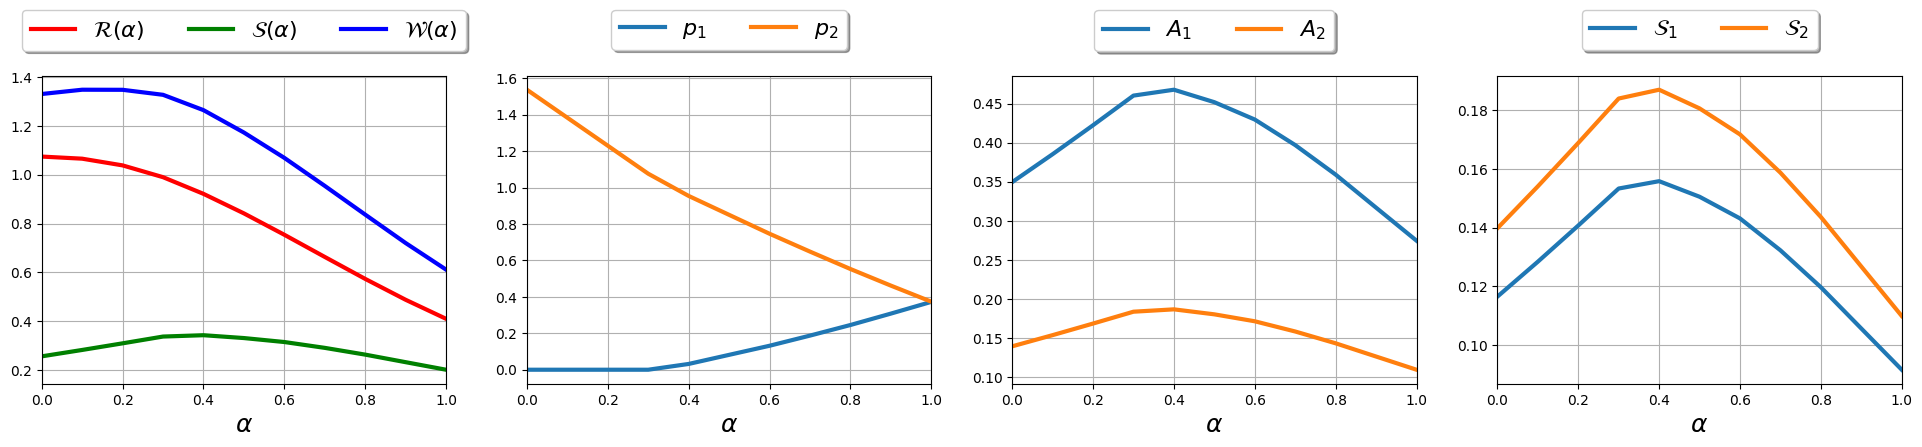

In [9]:
n = 2 # location
m = 1

# market = {(i,j): 1 for i in range(1,n+1) for j in range(1,n+1) if i != j}
# market.update({(i,j): 0 for i in range(1,n+1) for j in range(1,n+1) if i == j})
# b = {(i,j): 1 for i in range(1,n+1) for j in range(1,n+1)}
market, b = {}, {}
market[1,2] = 2
market[2,1] = 5
b[1,2] = 3
b[2,1] = 1

_ = simulator(market, b, n, m, criteria='Price', alpha_list = None)

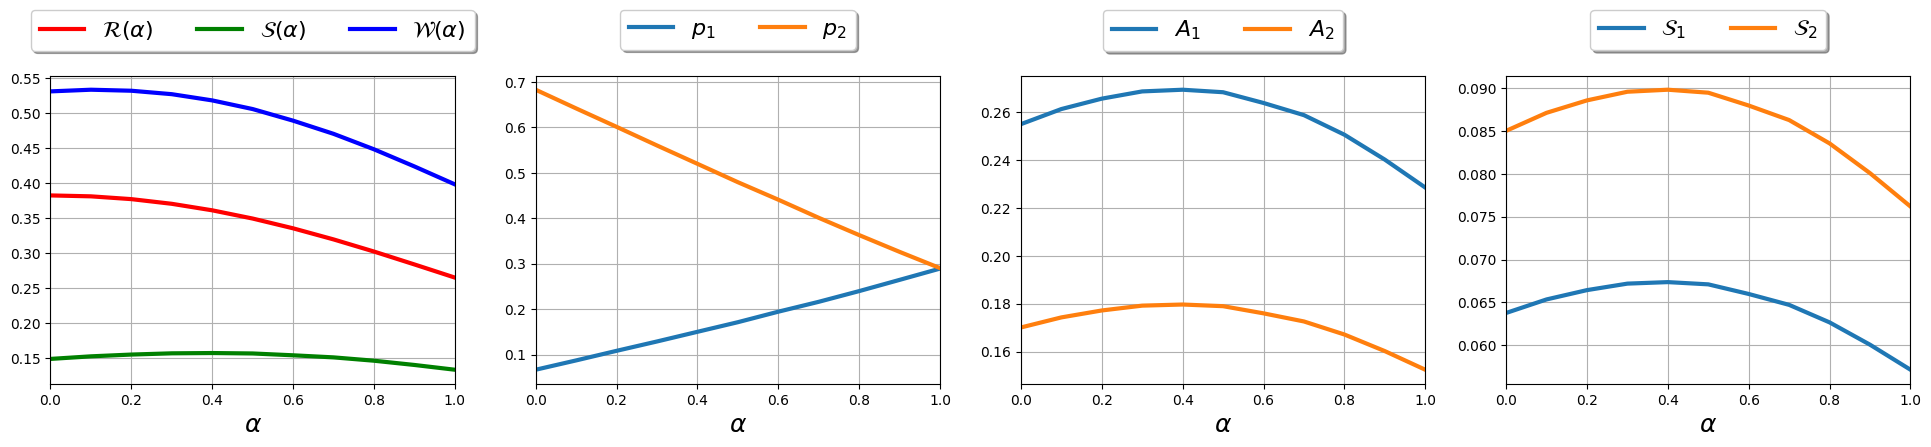

In [10]:
n = 2 # location
m = 1

market, b = {}, {}
market[1,2] = 2
market[2,1] = 3
b[1,2] = 4
b[2,1] = 2

_ = simulator(market, b, n, m, criteria='Price', alpha_list = None)

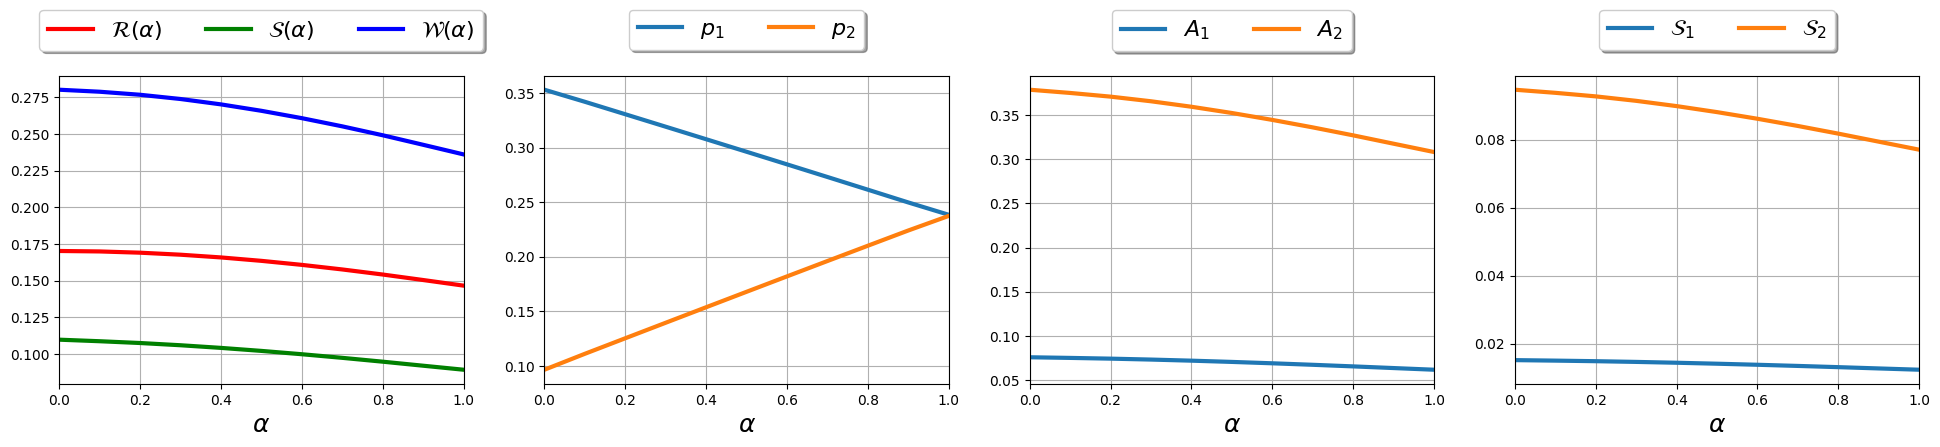

In [11]:
n = 2 # location
m = 1

market, b = {}, {}
market[1,2] = 5
market[2,1] = 1
b[1,2] = 5
b[2,1] = 4

_ = simulator(market, b, n, m, criteria='Price', alpha_list = None)

### Price Fairness (K = 10)

In [18]:
criteria = 'Price'

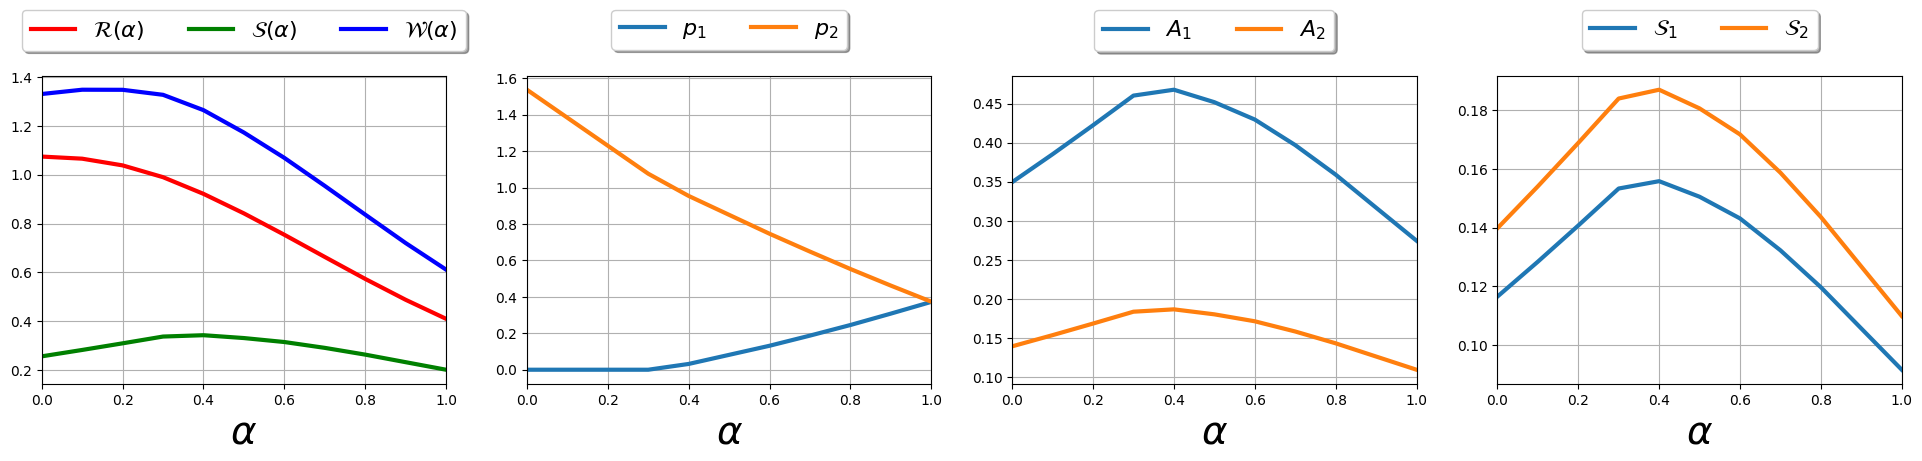

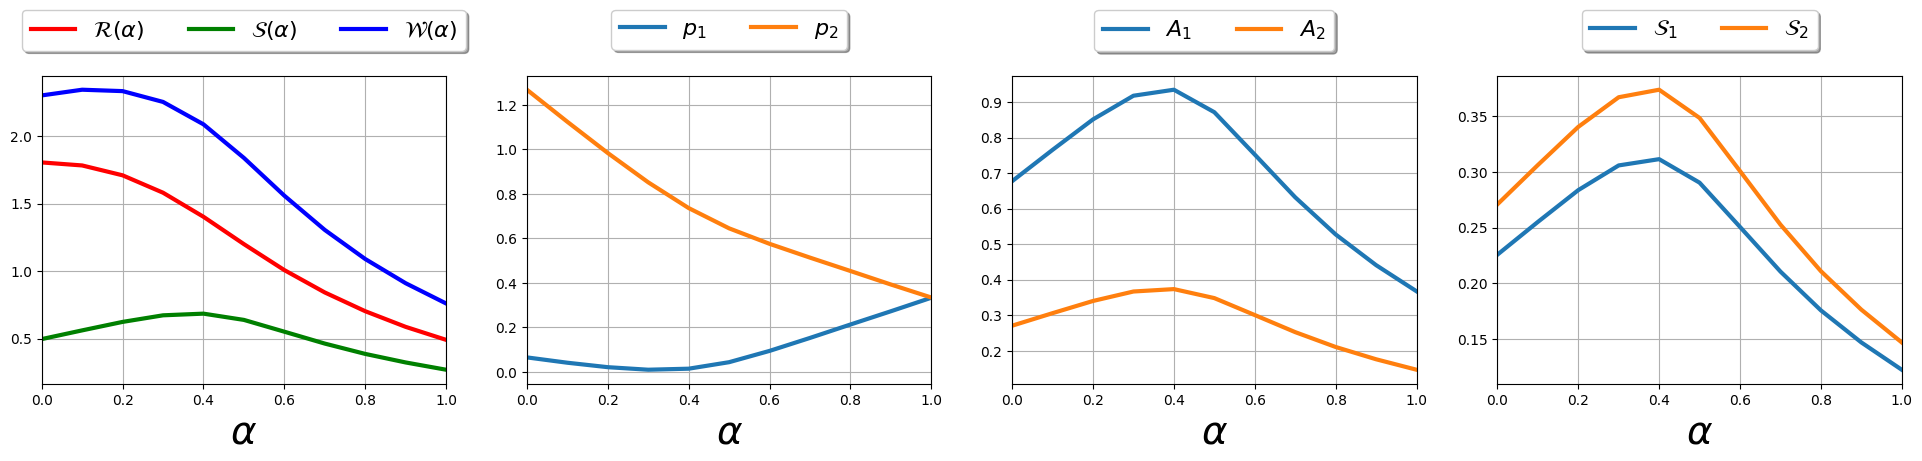

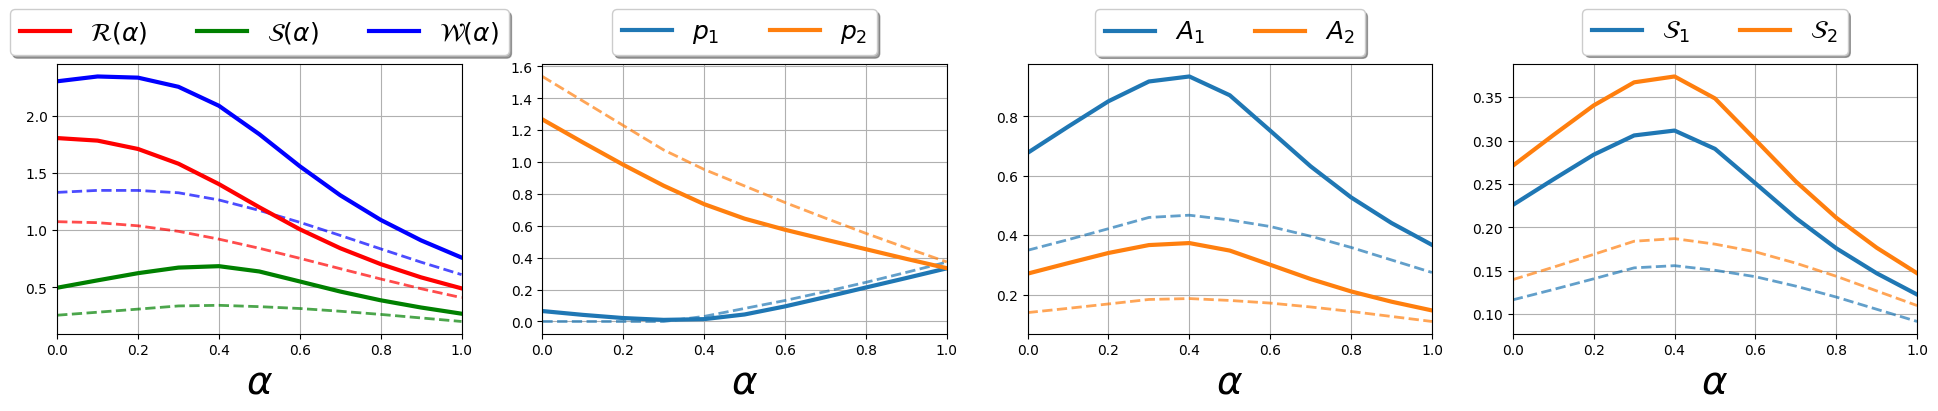

In [19]:
price_whole, revenue_whole, surplus_whole, total_surplus_whole, access_whole = [],[],[],[],[]
n = 2 # location
m = 1

market, b = {}, {}
market[1,2] = 2
market[2,1] = 5
b[1,2] = 3
b[2,1] = 1

for m in [1, 10]:
  p_list, revenue_list, surplus_list, total_surplus_list, a_list = simulator(market, b, n, m, criteria=criteria, alpha_list = None)
  price_whole.append(p_list)
  revenue_whole.append(revenue_list)
  surplus_whole.append(surplus_list)
  total_surplus_whole.append(total_surplus_list)
  access_whole.append(a_list)

subplot_overlapping(price_whole, revenue_whole, surplus_whole, total_surplus_whole, access_whole)

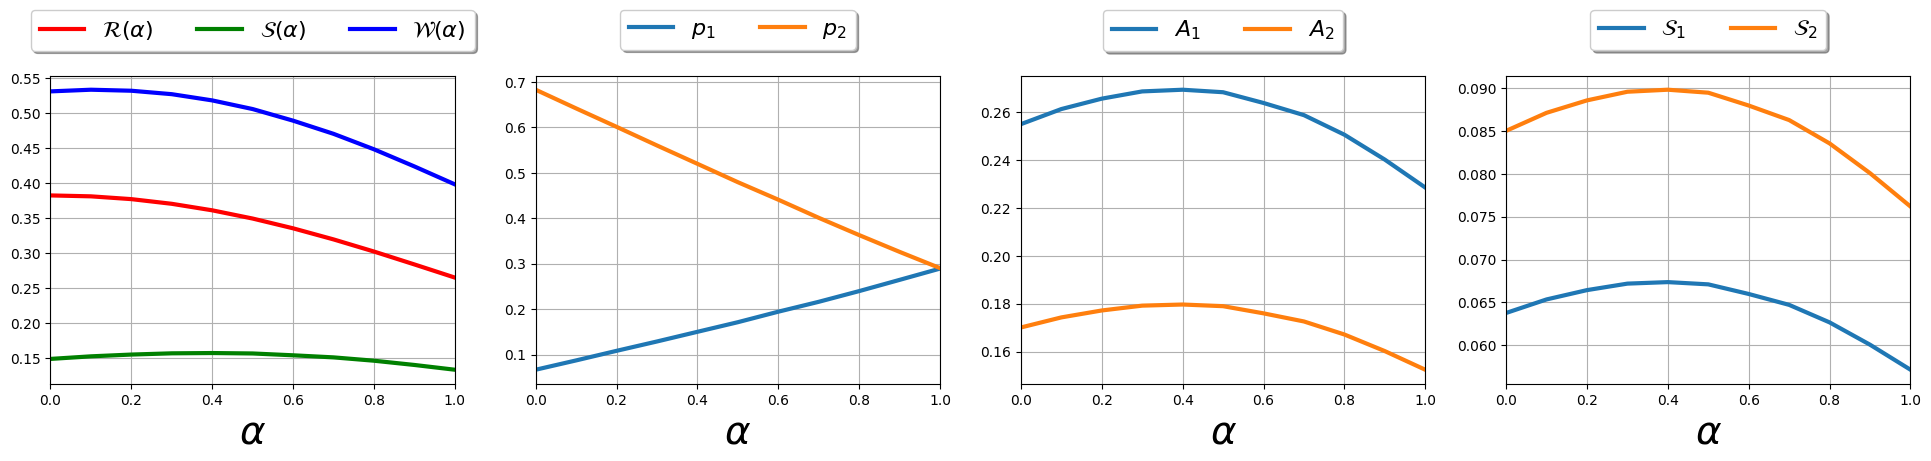

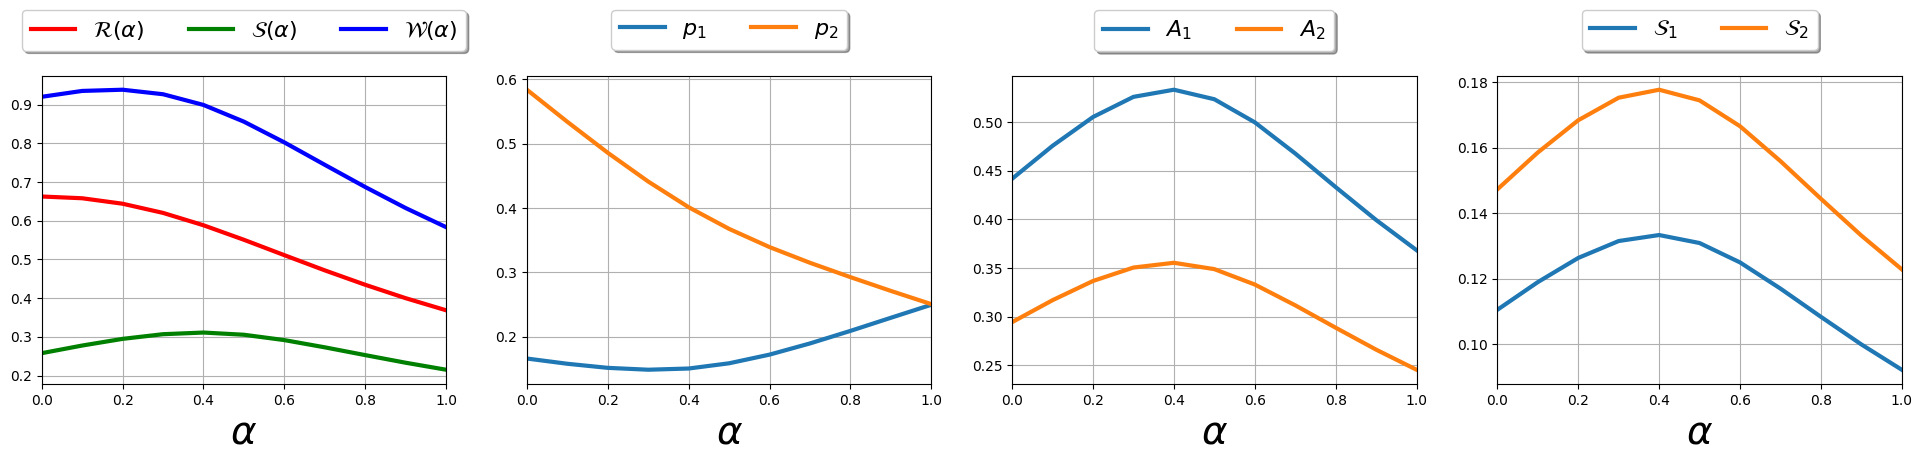

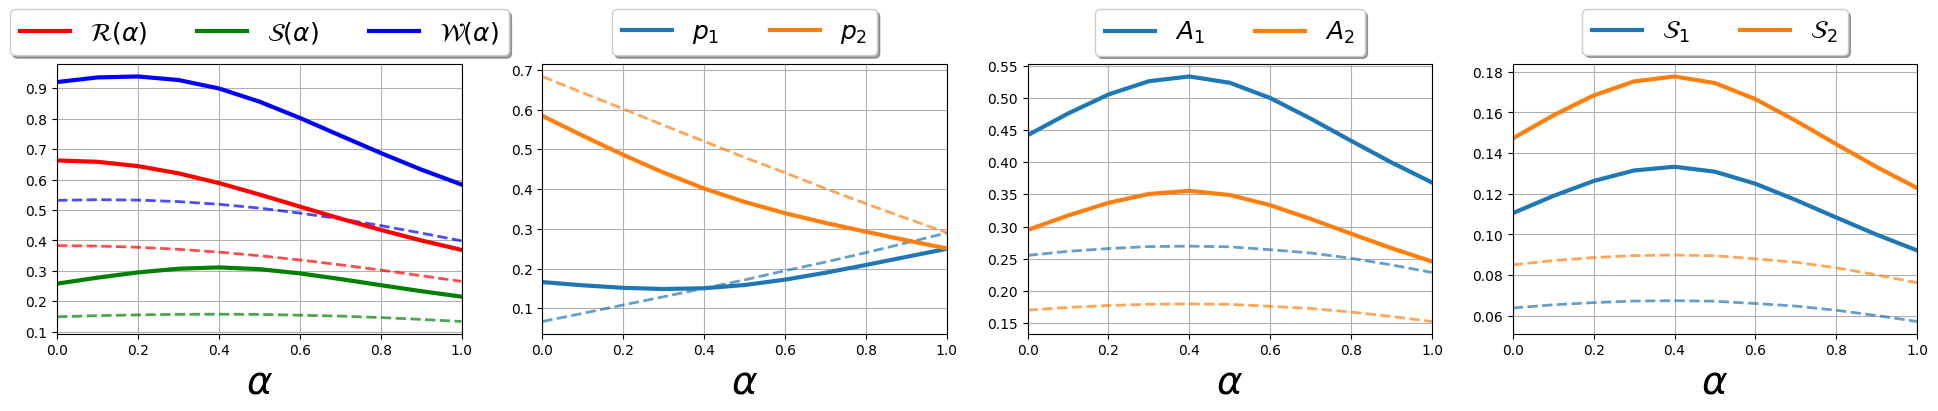

In [20]:
price_whole, revenue_whole, surplus_whole, total_surplus_whole, access_whole = [],[],[],[],[]
n = 2 # location
m = 1

market, b = {}, {}
market[1,2] = 2
market[2,1] = 3
b[1,2] = 4
b[2,1] = 2

for m in [1, 10]:
  p_list, revenue_list, surplus_list, total_surplus_list, a_list = simulator(market, b, n, m, criteria=criteria, alpha_list = None)
  price_whole.append(p_list)
  revenue_whole.append(revenue_list)
  surplus_whole.append(surplus_list)
  total_surplus_whole.append(total_surplus_list)
  access_whole.append(a_list)

subplot_overlapping(price_whole, revenue_whole, surplus_whole, total_surplus_whole, access_whole)

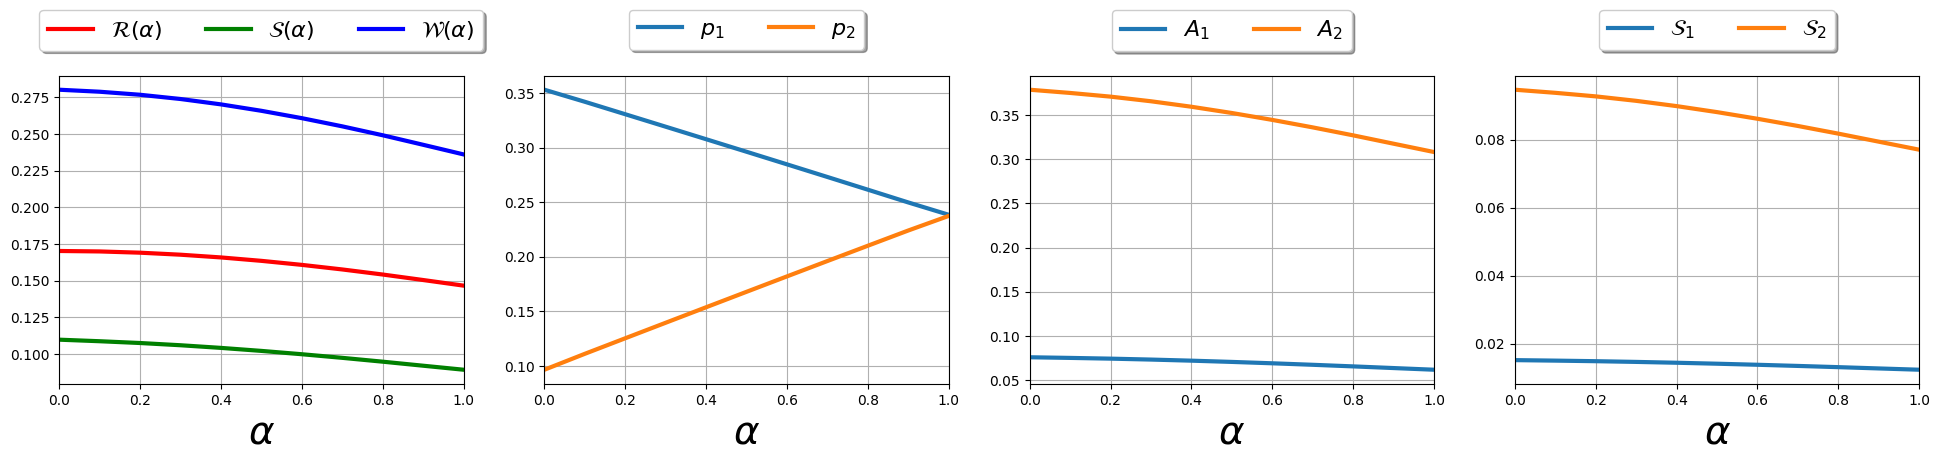

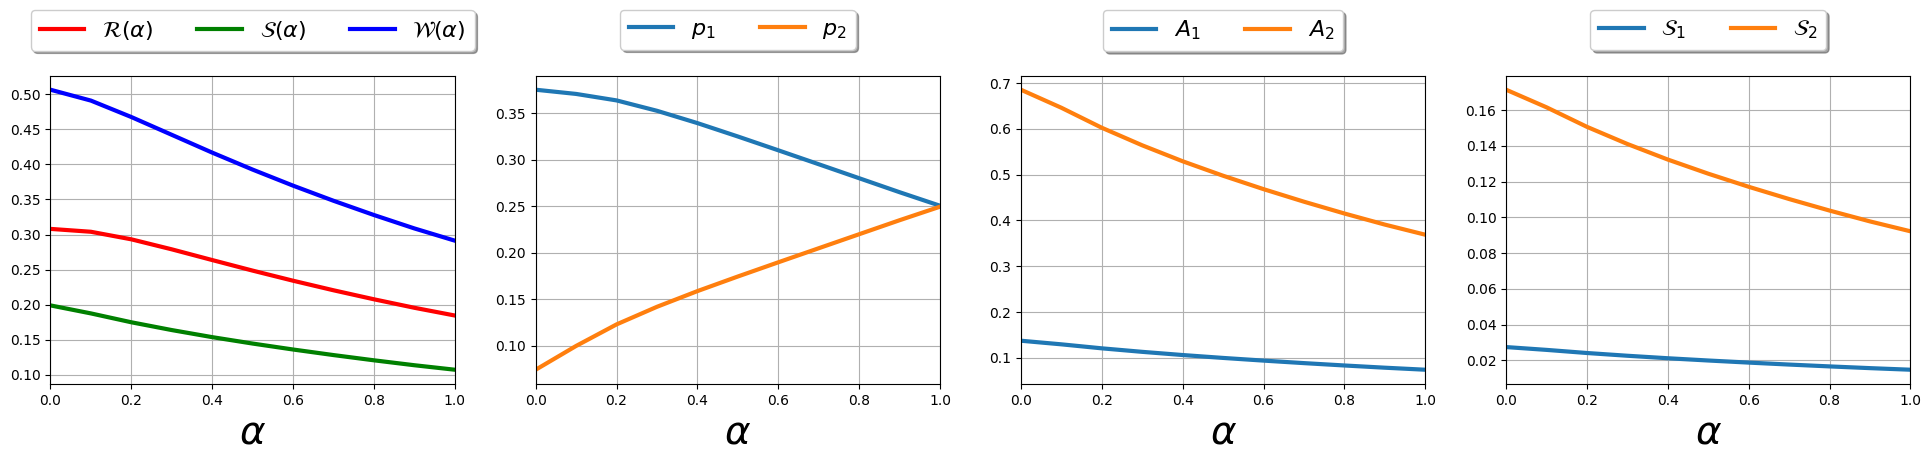

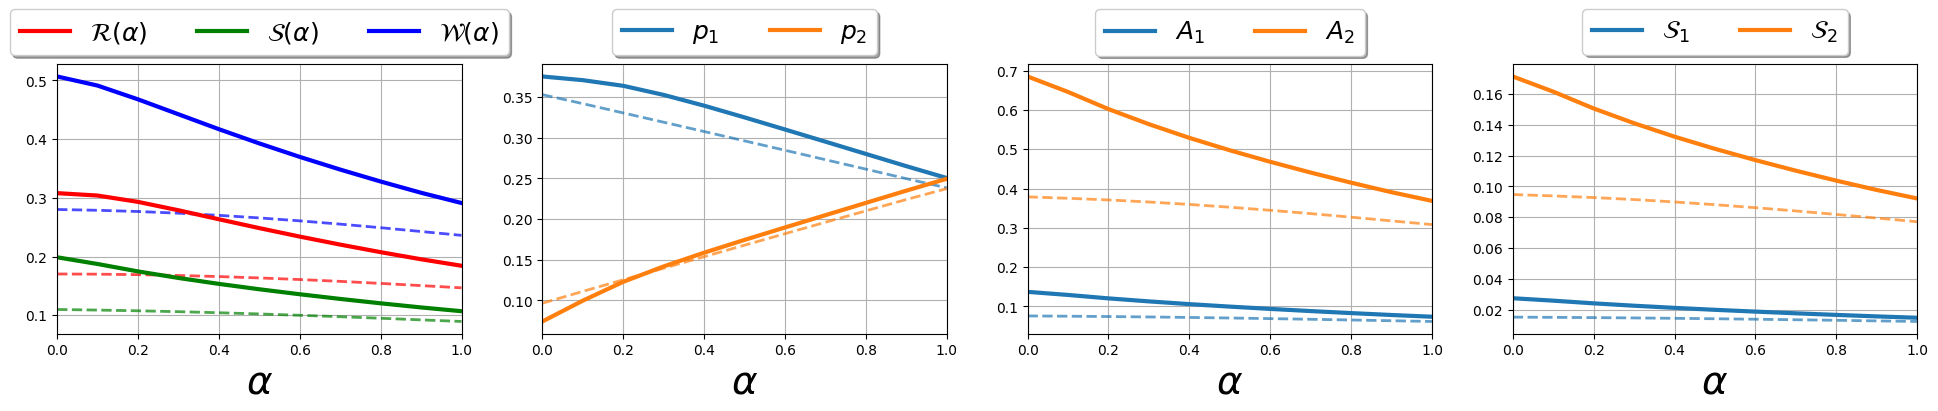

In [21]:
price_whole, revenue_whole, surplus_whole, total_surplus_whole, access_whole = [],[],[],[],[]
n = 2 # location
m = 1

market, b = {}, {}
market[1,2] = 5
market[2,1] = 1
b[1,2] = 5
b[2,1] = 4

for m in [1, 10]:
  p_list, revenue_list, surplus_list, total_surplus_list, a_list = simulator(market, b, n, m, criteria=criteria, alpha_list = None)
  price_whole.append(p_list)
  revenue_whole.append(revenue_list)
  surplus_whole.append(surplus_list)
  total_surplus_whole.append(total_surplus_list)
  access_whole.append(a_list)

subplot_overlapping(price_whole, revenue_whole, surplus_whole, total_surplus_whole, access_whole)

### Access Fairness ($K=1$ and $K=10$)

In [22]:
criteria = 'Access'

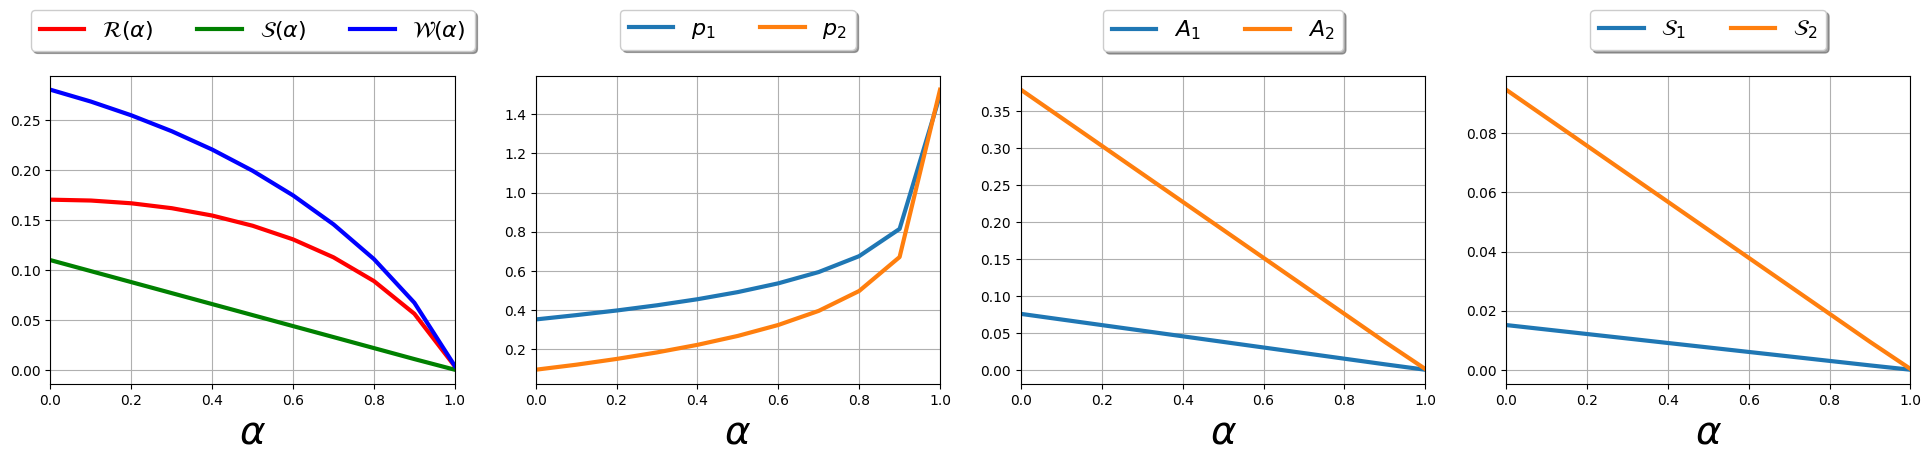

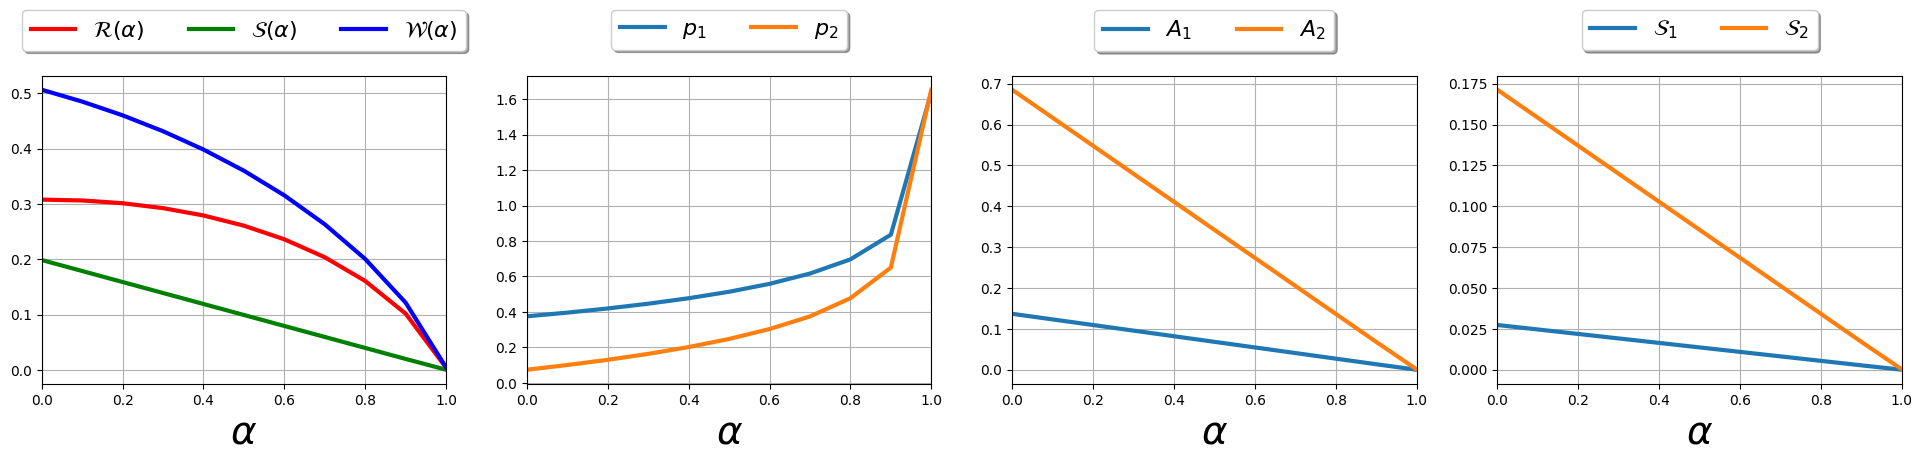

In [23]:
price_whole, revenue_whole, surplus_whole, total_surplus_whole, access_whole = [],[],[],[],[]

n = 2 # location
m = 1

market, b = {}, {}
market[1,2] = 5
market[2,1] = 1
b[1,2] = 5
b[2,1] = 4

for m in [1, 10]:
  p_list, revenue_list, surplus_list, total_surplus_list, a_list = simulator(market, b, n, m, criteria=criteria, alpha_list = None)
  price_whole.append(p_list)
  revenue_whole.append(revenue_list)
  surplus_whole.append(surplus_list)
  total_surplus_whole.append(total_surplus_list)
  access_whole.append(a_list)

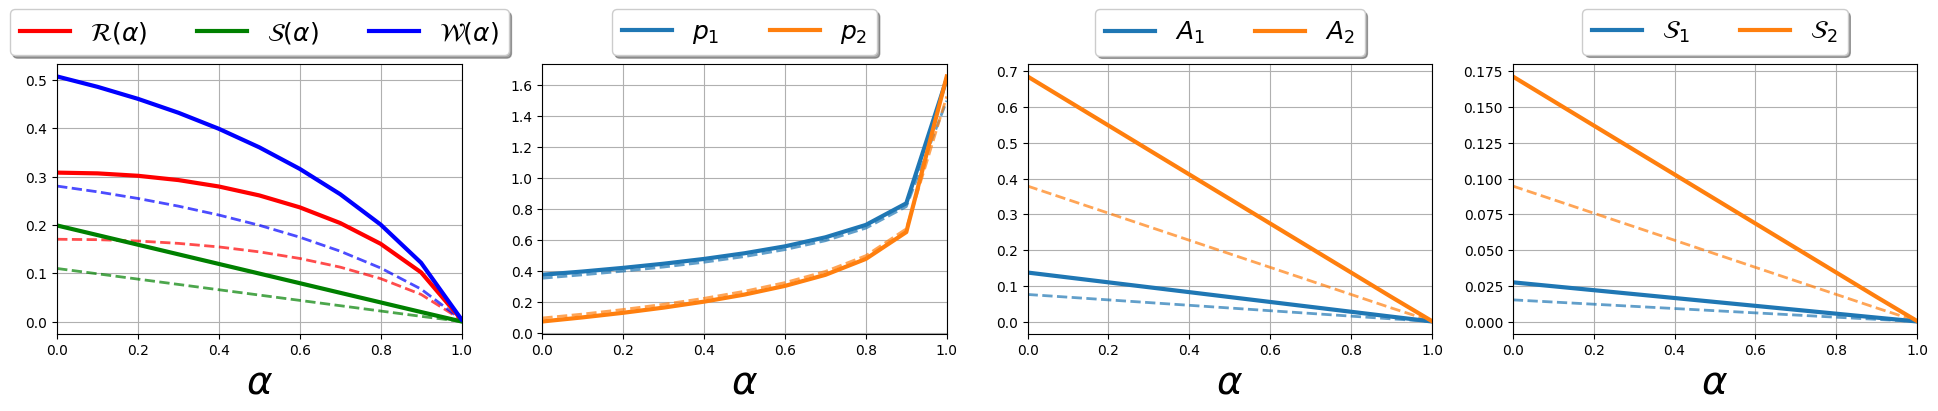

In [24]:
subplot_overlapping(price_whole, revenue_whole, surplus_whole, total_surplus_whole, access_whole)

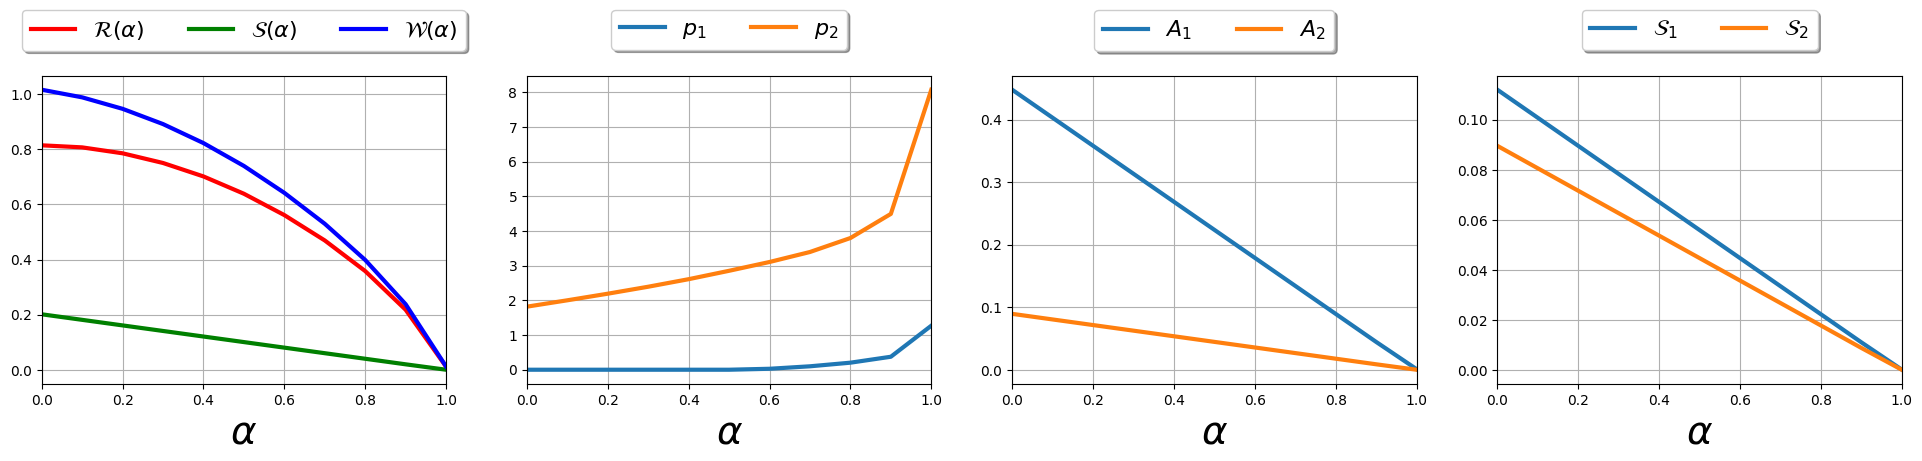

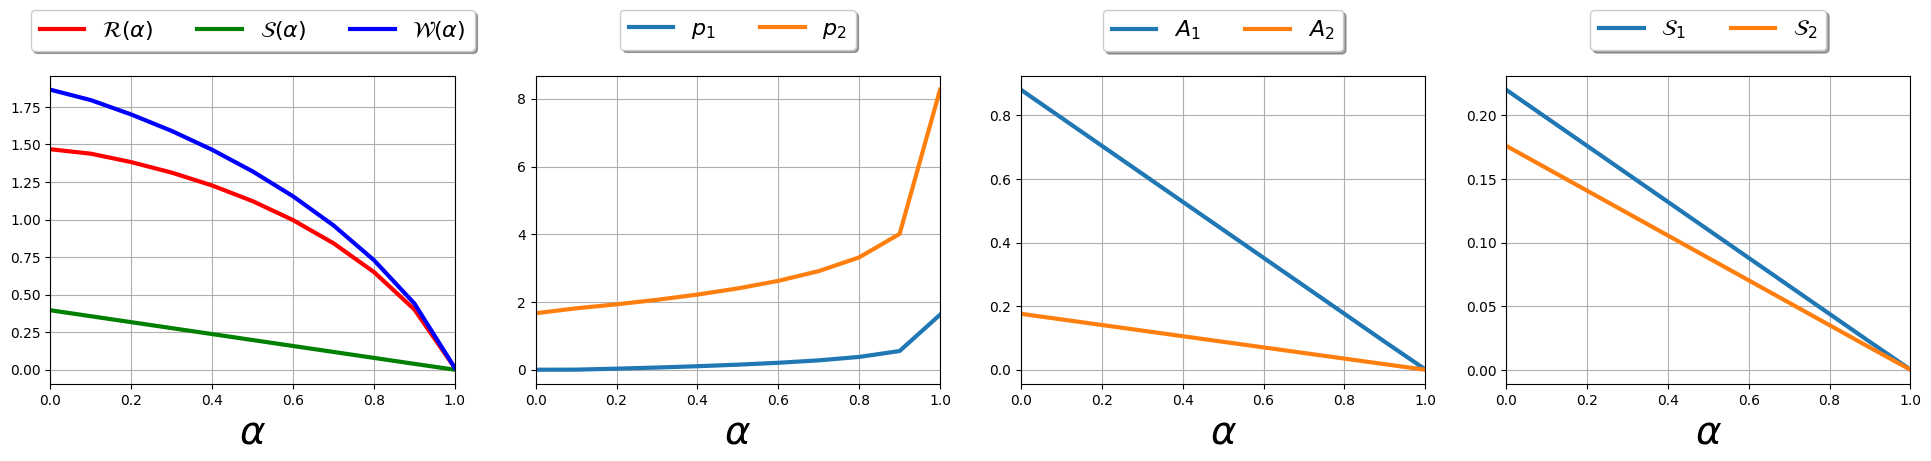

In [25]:
price_whole, revenue_whole, surplus_whole, total_surplus_whole, access_whole = [],[],[],[],[]
n = 2
m = 1

market, b = {}, {}
market[1,2] = 1
market[2,1] = 5
b[1,2] = 4
b[2,1] = 1

for m in [1, 10]:
  p_list, revenue_list, surplus_list, total_surplus_list, a_list = simulator(market, b, n, m, criteria=criteria, alpha_list = None)
  price_whole.append(p_list)
  revenue_whole.append(revenue_list)
  surplus_whole.append(surplus_list)
  total_surplus_whole.append(total_surplus_list)
  access_whole.append(a_list)

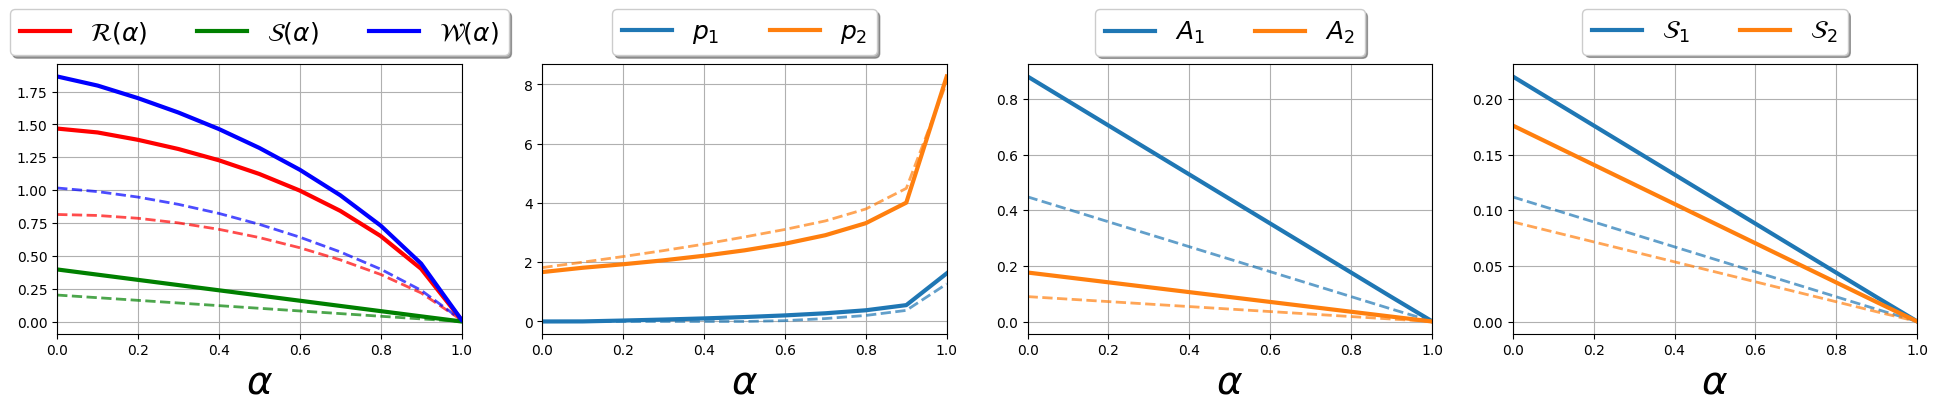

In [26]:
subplot_overlapping(price_whole, revenue_whole, surplus_whole, total_surplus_whole, access_whole)